In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
import glob
import warnings
warnings.filterwarnings('ignore')

2025-07-17 20:32:48.857221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752784369.042017      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752784369.095958      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# CONFIGURATION AND CONSTANTS

DATASET_PATH = "/kaggle/input/hand-gesture-movement/leapGestRecog/04"

# Gesture classes mapping
GESTURE_CLASSES = {
    0: 'palm', 1: 'I', 2: 'fist', 3: 'fist_moved', 4: 'thumb',
    5: 'index', 6: 'ok', 7: 'palm_moved', 8: 'c', 9: 'down'
}

# Folder mapping for dataset
FOLDER_MAPPING = {
    '01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4,
    '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9
}

In [4]:
# Configuration
IMG_SIZE = 64
BATCH_SIZE = 16 
EPOCHS = 50
LEARNING_RATE = 0.0001  

In [5]:
# DATA LOADING AND PREPROCESSING

def load_and_preprocess_data():
    """Load and preprocess the gesture dataset"""
    print("Loading dataset...")
    
    images = []
    labels = []
    
    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        print("Available paths:", os.listdir('/kaggle/input/'))
        return None, None
    
    # Load images from each folder
    for folder, class_idx in FOLDER_MAPPING.items():
        folder_path = os.path.join(DATASET_PATH, folder)
        if os.path.exists(folder_path):
            print(f"Loading {folder}...")
            
            image_files = glob.glob(os.path.join(folder_path, "*.png"))
            print(f"  Found {len(image_files)} images")
            
            for img_path in image_files:
                try:
                    # Load image in grayscale
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize and normalize
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        img = img.astype('float32') / 255.0
                        
                        images.append(img)
                        labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\nDataset loaded successfully!")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Number of classes: {len(np.unique(labels))}")
    
    return images, labels

# Load the dataset
X, y = load_and_preprocess_data()

Loading dataset...
Loading 01_palm...
  Found 200 images
Loading 02_l...
  Found 200 images
Loading 03_fist...
  Found 200 images
Loading 04_fist_moved...
  Found 200 images
Loading 05_thumb...
  Found 200 images
Loading 06_index...
  Found 200 images
Loading 07_ok...
  Found 200 images
Loading 08_palm_moved...
  Found 200 images
Loading 09_c...
  Found 200 images
Loading 10_down...
  Found 200 images

Dataset loaded successfully!
Total images: 2000
Image shape: (2000, 64, 64)
Number of classes: 10


Visualizing sample images...


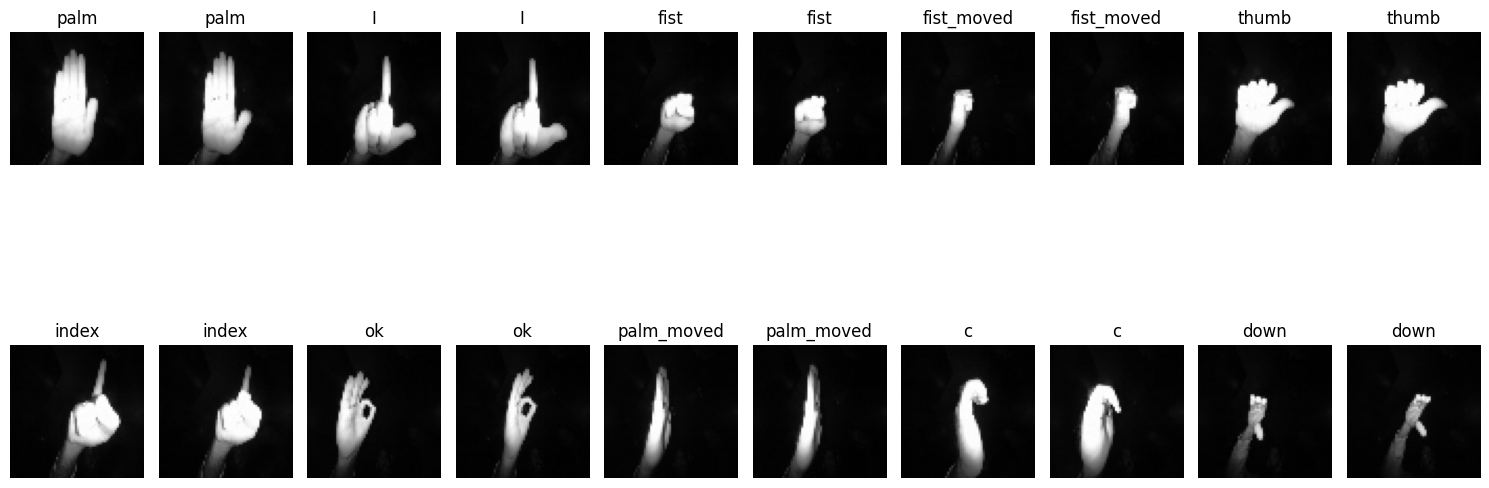

Class distribution:


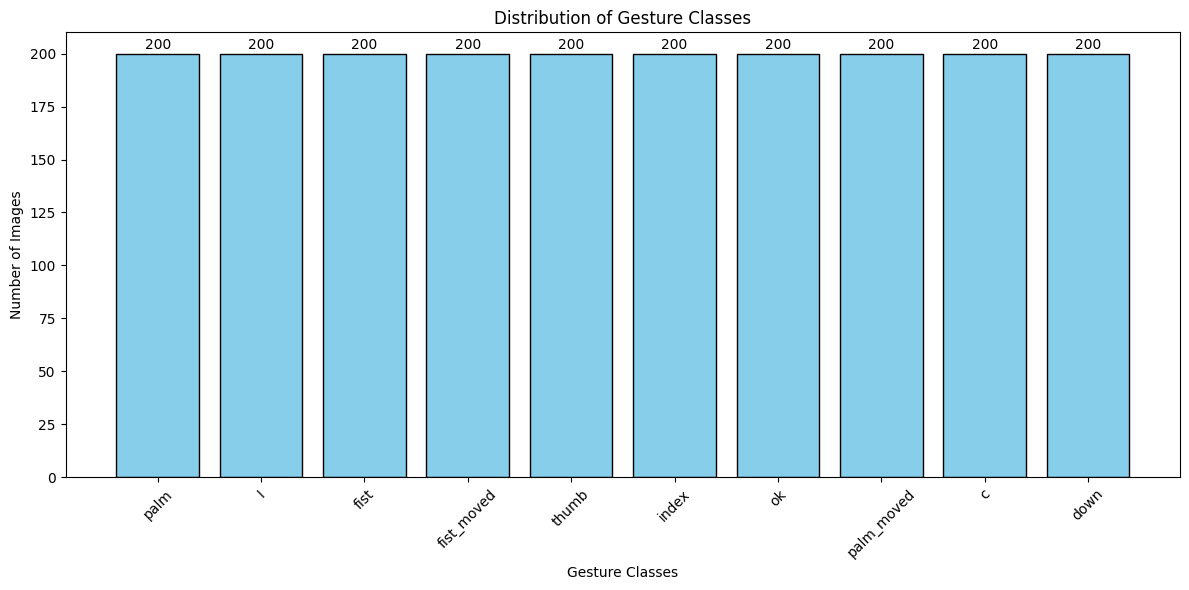

In [6]:
# DATA VISUALIZATION

def visualize_samples(images, labels, samples_per_class=2):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15, 8))
    
    plot_idx = 1
    for class_idx in range(len(GESTURE_CLASSES)):
        # Find images of this class
        class_indices = np.where(labels == class_idx)[0]
        
        if len(class_indices) >= samples_per_class:
            # Select random samples
            sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            
            for sample_idx in sample_indices:
                plt.subplot(2, 10, plot_idx)
                plt.imshow(images[sample_idx], cmap='gray')
                plt.title(f'{GESTURE_CLASSES[class_idx]}')
                plt.axis('off')
                plot_idx += 1
    
    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels):
    """Plot distribution of classes"""
    plt.figure(figsize=(12, 6))
    
    unique, counts = np.unique(labels, return_counts=True)
    class_names = [GESTURE_CLASSES[i] for i in unique]
    
    bars = plt.bar(class_names, counts, color='skyblue', edgecolor='black')
    plt.title('Distribution of Gesture Classes')
    plt.xlabel('Gesture Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Visualize the dataset
if X is not None and y is not None:
    print("Visualizing sample images...")
    visualize_samples(X, y)
    
    print("Class distribution:")
    plot_class_distribution(y)

In [7]:
# DATA PREPARATION

def prepare_data(X, y):
    """Prepare data for training"""
    # Reshape for CNN (add channel dimension)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    
    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Prepare the data
if X is not None and y is not None:
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

Training set: 1500 images
Validation set: 250 images
Test set: 250 images


In [8]:
# MODEL CREATION

def create_model():
    """Create CNN model for gesture recognition"""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
# Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(GESTURE_CLASSES), activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_model()
model.summary()

I0000 00:00:1752784398.428729      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752784398.429579      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,048,458 (4.00 MB)

 Trainable params: 1,047,498 (4.00 MB)

 Non-trainable params: 960 (3.75 KB)

Training the model...


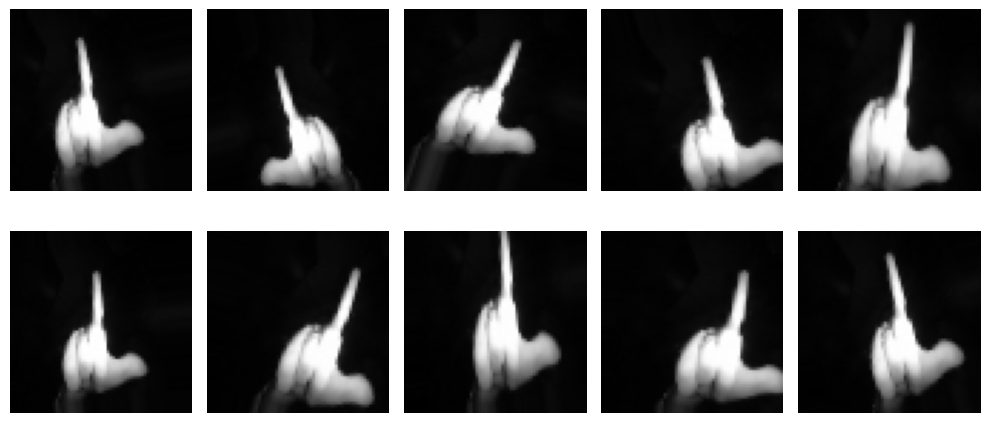

Epoch 1/50


I0000 00:00:1752784405.599179      66 service.cc:148] XLA service 0x7ff2f4001610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752784405.600179      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752784405.600208      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752784406.194358      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0946 - loss: 4.4487

I0000 00:00:1752784410.758848      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.1604 - loss: 3.4946 - val_accuracy: 0.1000 - val_loss: 2.6618 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3525 - loss: 1.8626 - val_accuracy: 0.1920 - val_loss: 3.2756 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4798 - loss: 1.3767 - val_accuracy: 0.1000 - val_loss: 6.0138 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5800 - loss: 1.1464 - val_accuracy: 0.1000 - val_loss: 7.1563 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6922 - loss: 0.8245 - val_accuracy: 0.1000 - val_loss: 7.7210 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7731 - loss: 0.6779 - val_accuracy: 0.5920 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7969 - loss: 0.5632 - val_accuracy: 0.9

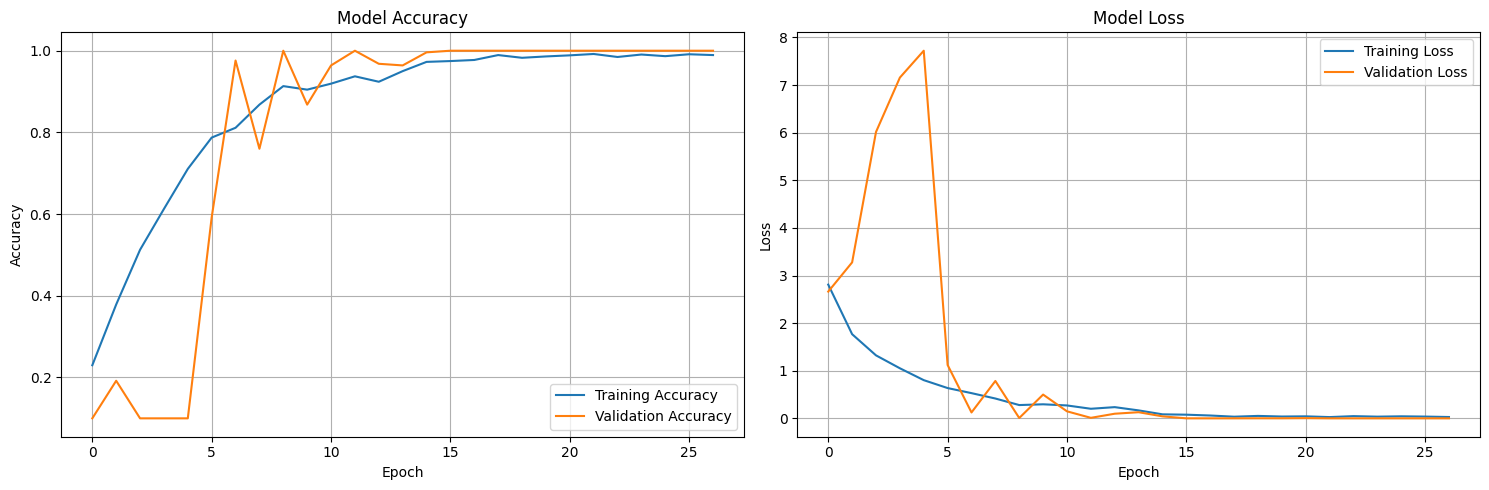

In [9]:
# MODEL TRAINING

def train_model(model, X_train, y_train, X_val, y_val):
    """Train the model"""
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    # Visualize augmented images
    sample = X_train[0].reshape(1, IMG_SIZE, IMG_SIZE, 1)
    plt.figure(figsize=(10, 5))

    for i, batch in enumerate(datagen.flow(sample, batch_size=1)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(batch[0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.axis('off')
        if i == 9:
            break
    plt.tight_layout()
    plt.show()

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )
    
    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history

# Train the model
if 'X_train' in locals():
    print("Training the model...")
    history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Plot training history
    def plot_training_history(history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    plot_training_history(history)

Evaluating the model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        palm       1.00      1.00      1.00        25
           I       1.00      1.00      1.00        25
        fist       1.00      1.00      1.00        25
  fist_moved       1.00      1.00      1.00        25
       thumb       1.00      1.00      1.00        25
       index       1.00      1.00      1.00        25
          ok       1.00      1.00      1.00        25
  palm_moved       1.00      1.00      1.00        25
           c       1.00      1.00      1.00        25
        down       1.00      1.00      1.00        25

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



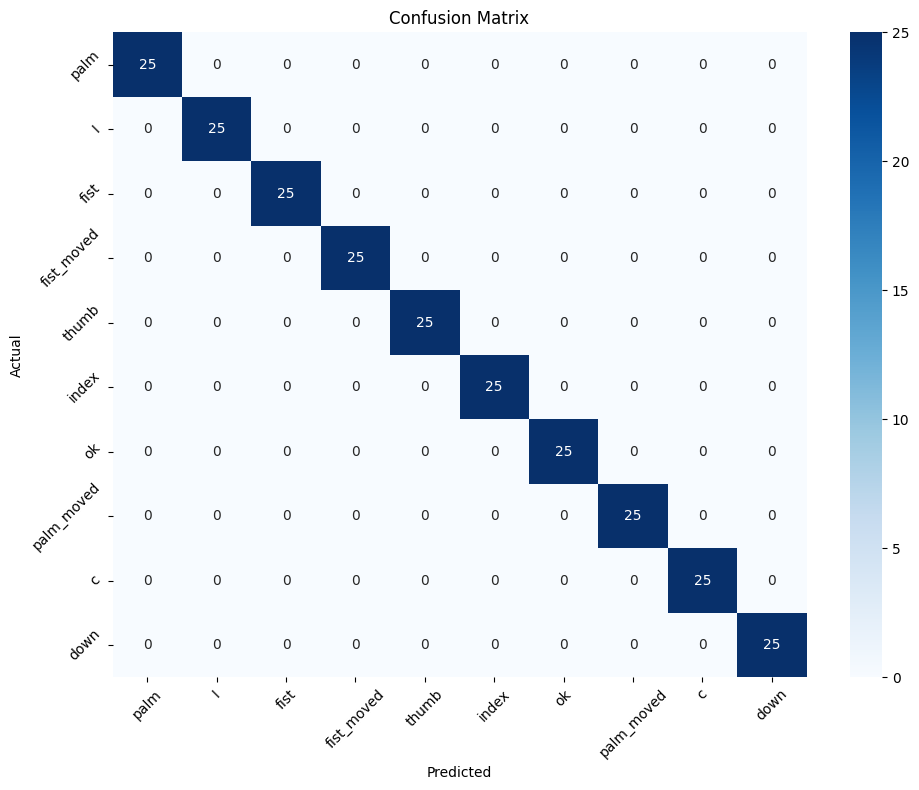

In [10]:
# MODEL EVALUATION

def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_classes == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                               target_names=list(GESTURE_CLASSES.values())))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(GESTURE_CLASSES.values()),
                yticklabels=list(GESTURE_CLASSES.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_pred_classes

# Evaluate the model
if 'X_test' in locals():
    print("Evaluating the model...")
    y_pred, y_pred_classes = evaluate_model(model, X_test, y_test)

Testing with random samples from test set...


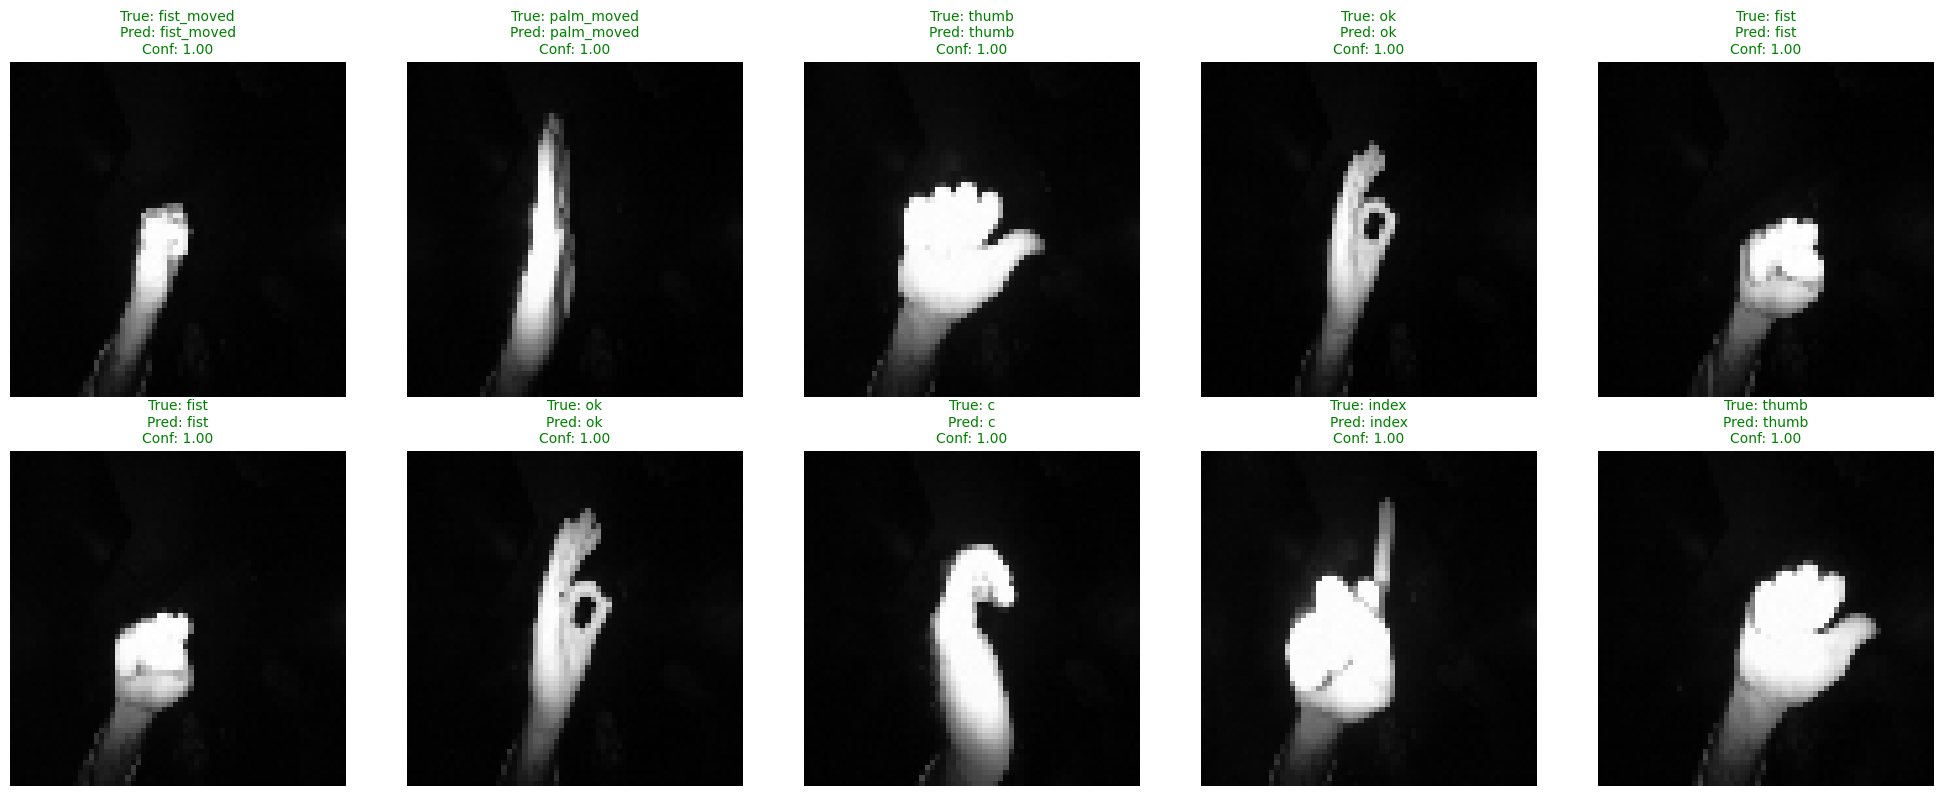

In [11]:
# PREDICTION FUNCTIONS

def predict_gesture(model, image_path):
    """
    Predict gesture from a single image
    Returns: dict with gesture_name, gesture_index, confidence, image
    """
    try:
        # Load image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not load image: {image_path}")
            return None
        
        # Preprocess
        original_img = img.copy()
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32') / 255.0
        img_input = np.expand_dims(np.expand_dims(img, axis=0), axis=-1)
        
        # Predict
        prediction = model.predict(img_input, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        # Visualize result
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Processed image
        axes[1].imshow(img, cmap='gray')
        axes[1].set_title('Processed (64x64)')
        axes[1].axis('off')
        
        # Prediction probabilities
        axes[2].bar(range(len(GESTURE_CLASSES)), prediction[0])
        axes[2].set_title(f'Prediction: {GESTURE_CLASSES[predicted_class]}\nConfidence: {confidence:.2f}')
        axes[2].set_xlabel('Gesture Classes')
        axes[2].set_ylabel('Probability')
        axes[2].set_xticks(range(len(GESTURE_CLASSES)))
        axes[2].set_xticklabels([GESTURE_CLASSES[i] for i in range(len(GESTURE_CLASSES))], rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'gesture_name': GESTURE_CLASSES[predicted_class],
            'gesture_index': predicted_class,
            'confidence': confidence,
            'image': img
        }
        
    except Exception as e:
        print(f"Error predicting gesture: {e}")
        return None

def test_with_random_samples(model, X_test, y_test, num_samples=10):
    """Test model with random samples from test set"""
    
    # Select random samples
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    plt.figure(figsize=(20, 8))
    
    for i, idx in enumerate(sample_indices):
        # Get sample
        sample_img = X_test[idx]
        true_label = y_test[idx]
        
        # Predict
        prediction = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        # Plot
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_img.squeeze(), cmap='gray')
        
        true_gesture = GESTURE_CLASSES[true_label]
        pred_gesture = GESTURE_CLASSES[predicted_class]
        color = 'green' if predicted_class == true_label else 'red'
        
        plt.title(f'True: {true_gesture}\nPred: {pred_gesture}\nConf: {confidence:.2f}', 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with random samples
if 'model' in locals() and 'X_test' in locals():
    print("Testing with random samples from test set...")
    test_with_random_samples(model, X_test, y_test)

In [12]:
def predict_user_image(model, image_path):
    """
    Predict a gesture for a user-provided image.
    Shows:
      - Original image
      - Preprocessed (64x64) image
      - Predicted gesture name
    """
    IMG_SIZE = 64  # same as before

    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Keep original for display
    original_img = img.copy()

    # Resize & normalize
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype('float32') / 255.0

    # Add batch and channel dimensions
    img_input = np.expand_dims(img_norm, axis=(0, -1))

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)

    predicted_gesture = GESTURE_CLASSES[predicted_index]

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Predicted: {predicted_gesture} ({confidence:.2f})")
    plt.axis('off')

    plt.show()

    print(f"Predicted Gesture: {predicted_gesture} (Index: {predicted_index}) | Confidence: {confidence:.2f}")

    return predicted_gesture, predicted_index, confidence



Processing: /kaggle/input/my-hand/5a5a331d-8753-4e86-8965-19cb8ba168cd.jpg


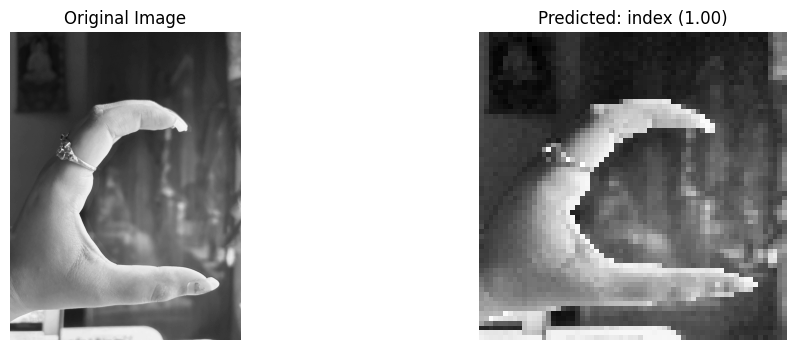

Predicted Gesture: index (Index: 5) | Confidence: 1.00

Processing: /kaggle/input/my-hand/803e6b10-001a-462c-a25e-274ae697a1ad.jpg


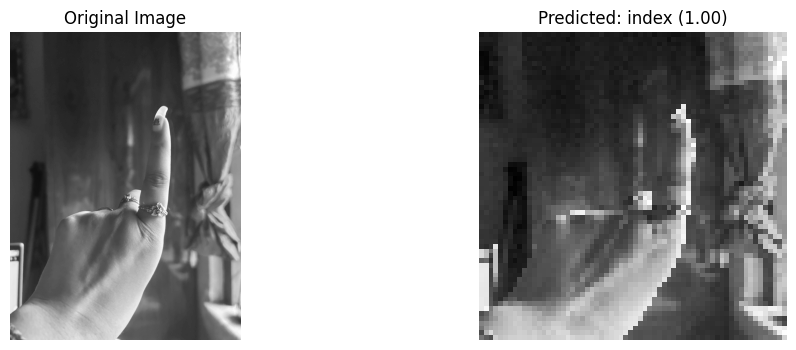

Predicted Gesture: index (Index: 5) | Confidence: 1.00

Processing: /kaggle/input/my-hand/8f17c1f9-2918-4a08-8a93-1eeecf1936d9.jpg


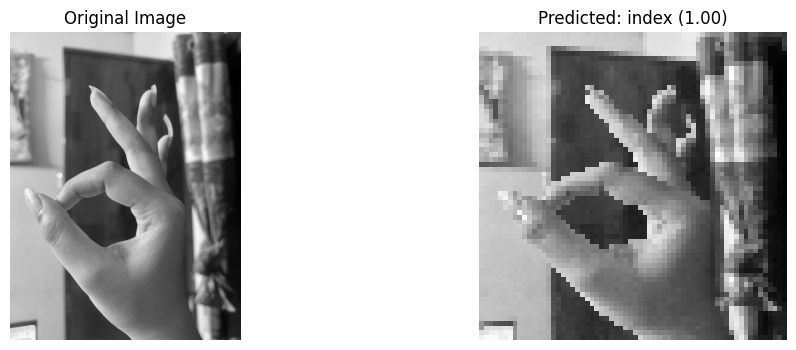

Predicted Gesture: index (Index: 5) | Confidence: 1.00


In [13]:
# --- Define list of image paths ---
image_paths = [
    "/kaggle/input/my-hand/5a5a331d-8753-4e86-8965-19cb8ba168cd.jpg",
    "/kaggle/input/my-hand/803e6b10-001a-462c-a25e-274ae697a1ad.jpg",
    "/kaggle/input/my-hand/8f17c1f9-2918-4a08-8a93-1eeecf1936d9.jpg"
]

# --- Predict on each image ---
for image_path in image_paths:
    print(f"\nProcessing: {image_path}")
    predict_user_image(model, image_path)
